Semi-Supervised Learning for Credit-Card Approval Project

Introduction: 
Dataset, that has been retrieved from remote server has over 90% of unlabeled data and 
at most 10% respectively. We need to predict labels of bad client for over 460000 samples, based on 
user personal information, provided. This Notebook prepares the dataset for the potential re-tranining by 
using semi-supervised learning technique

In [512]:
# let's start by loading the dataset 
import pandas, numpy
applications = pandas.read_csv("application_record.csv")
credit_records = pandas.read_csv("credit_record.csv")

In [513]:
# labeling data, presented in the credit records 

# Relabling Credit Records Dataset

CREDIT_MAPPING = {
    "ID": "client_id",
    "STATUS": "due_status",
    "MONTHS_BALANCE": "balance_month"
}
credit_records.rename(columns=CREDIT_MAPPING, inplace=True)

# Relabling Applications Records Dataset
APPLICATION_MAPPING = {
    "ID": "client_id",
    "CODE_GENDER": "gender",
    "FLAG_OWN_CAR": "has_car",
    "FLAG_OWN_REALTY": "has_realty",
    "CNT_CHILDREN": "total_children",
    "AMT_INCOME_TOTAL": "annual_income",
    "NAME_INCOME_TYPE": "income_category",
    "NAME_EDUCATION_TYPE": "education_category",
    "NAME_FAMILY_STATUS": "family_status",
    "NAME_HOUSING_TYPE": "living_place",
    "DAYS_BIRTH": "birthday",
    "FLAG_MOBIL": "has_mobile_phone",
    "FLAG_PHONE": "has_phone",
    "FLAG_WORK_PHONE": "has_work_phone",
    "FLAG_EMAIL": "has_email",
    "CNT_FAM_MEMBERS": "family_size",
    "OCCUPATION_TYPE": "job",
    'DAYS_EMPLOYED': 'days_employed',
}

applications.rename(columns=APPLICATION_MAPPING, inplace=True)


Null Values handling (Application Records)

In [514]:
applications.isnull().sum()

client_id                  0
gender                     0
has_car                    0
has_realty                 0
total_children             0
annual_income              0
income_category            0
education_category         0
family_status              0
living_place               0
birthday                   0
days_employed              0
has_mobile_phone           0
has_work_phone             0
has_phone                  0
has_email                  0
job                   134203
family_size                0
dtype: int64

In [515]:
missing_job = 'missing'
applications['job'].fillna(value=missing_job, inplace=True)

Null Values Handling (Credit Records)

In [516]:
credit_records.isna().sum()

client_id        0
balance_month    0
due_status       0
dtype: int64

Application Record Features

In [517]:
import math 

applications = applications.drop_duplicates(subset=["client_id"], keep='last', inplace=False)

applications['age'] = applications['birthday'].apply(lambda day: math.floor(abs(day) / 365))
applications['employed'] = applications['days_employed'].apply(lambda days: True if days < 0 else False)

dup_clients = applications['client_id'].value_counts().to_frame("number_of_apps").reset_index()
dup_clients['exp_applicant'] = numpy.where(dup_clients['number_of_apps'] > 1, True, False)

applications = applications.merge(dup_clients, on='client_id')
applications.drop(columns=['birthday', 'days_employed'], inplace=True)

In [518]:
# Cleansing credit records dataset 
DUE_DATATYPES = {
    "0": 0,
    "1": 0,
    "2": 1,
    "3": 1,
    "4": 1,
    "5": 1,
    "X": 0,
    "C": 0
}
credit_records['due_status'] = credit_records['due_status'].map(lambda item: DUE_DATATYPES[item])

Credit Record Features

In [519]:
# introducing credit records features (bad client status)
credit_features = pandas.DataFrame()
credit_features['client_id'] = credit_records['client_id'].unique()
credit_features['overdues'] = pandas.Series(credit_records.groupby('client_id')['due_status'].sum().to_numpy())
credit_features['credit_window'] = numpy.abs(credit_records['balance_month'].min())
credit_features['overdue_perc'] = numpy.round(credit_features['overdues'] / credit_features['credit_window'], 2)

# annotating bad client status
credit_features['bad_client'] = numpy.where(credit_features['overdues'] > 0, True, False)
credit_features = credit_features[['client_id', 'bad_client']]

credit_features['bad_client'].value_counts()

bad_client
False    45318
True       667
Name: count, dtype: int64

Merging tables together

In [520]:
merged_dataset = applications.merge(credit_features, on='client_id', how='left')
merged_dataset

,client_id,gender,has_car,has_realty,total_children,annual_income,income_category,education_category,family_status,living_place,...,has_work_phone,has_phone,has_email,job,family_size,age,employed,number_of_apps,exp_applicant,bad_client
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,missing,2.0,32,True,1,False,False
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,missing,2.0,32,True,1,False,False
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,2.0,58,True,1,False,False
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,52,True,1,False,False
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,52,True,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,...,0,0,0,missing,1.0,62,False,1,False,NaN
438506,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,Laborers,1.0,43,True,1,False,NaN
438507,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,...,1,0,0,Sales staff,1.0,22,True,1,False,NaN
438508,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,0,0,missing,2.0,59,False,1,False,NaN


Feature Encoding

In [521]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder 

def encode_bool_features(dataset: pandas.DataFrame):
    """
    Function standardizes boolean features to the following format 
        True: (Y, 1)
        False: (N, 0)
    Args:
        dataset: pandas.DataFrame object, containing boolean features
    """
    bool_features = ['has_car', 'has_realty', 'has_phone', 'has_email', 'has_mobile_phone']
    if not all(feature in dataset.columns for feature in bool_features): return 

    for feature in bool_features:
        dataset[feature] = dataset[feature].map(
            {
                'Y': True,
                'N': False,
                1: True,
                0: False
            }
        )

def encode_gender_feature(dataset: pandas.DataFrame):
    """
    Function encodes gender feature using One Hot Encoding

    Args:
        dataset: pandas.DataFrame object, containing gender feature
    """
    if not 'gender' in dataset.columns: return 
    encoded_data = pandas.get_dummies(dataset['gender']).rename(columns={'F': 'Female', 'M': 'Male'})

    dataset = pandas.concat([dataset, encoded_data], axis=1)
    dataset.drop(columns=['gender'], inplace=True)
    return dataset

def encode_family_status_feature(dataset: pandas.DataFrame):
    """
    Function encodes family status feature to boolean type, which represents marriage state:
        Married: True
        Non-Married: False
        
    Args:
        dataset: pandas.DataFrame object, containing family status feature
    """
    if not 'family_status' in dataset.columns: return 
    non_mar_statuses = set(['Single / not married', 'Separated', 'Widow'])
    dataset['family_status'] = dataset['family_status'].apply(
        func=lambda status: True if status not in non_mar_statuses else False
    )
    dataset.rename(columns={'family_status': 'married'}, inplace=True)


def encode_job_feature(dataset: pandas.DataFrame):
    """
    Function encodes job feature using Label Encoder

    Args:
        dataset: pandas.DataFrame object, containing job feature
    """
    if not 'job' in dataset.columns: return 

    encoder = LabelEncoder()
    dataset['job'] = encoder.fit_transform(dataset[['job']])


def encode_education_feature(dataset: pandas.DataFrame):
    """
    Function encodes education category feature using Ordinal Encoding 

    What steps function performs:

        1. Cleans and upgrades category labels 
        2. Selects the right education order (hierarchy) in descending order (Academic Degree, Higher Education, ...)
        3. Encodes Categories 

    Args:
        dataset: pandas.DataFrame object, containing education feature
    """
    if not 'education_category' in dataset.columns: return 

    dataset['education_category'] = dataset['education_category'].map({
    'Secondary / secondary special': 'special secondary',
    'Incomplete higher': 'incomplete higher education',
    'Academic degree': 'academic degree',
    'Higher education': 'higher education',
    'Lower secondary': 'lower secondary'
    })

    education_categories = [
        "academic degree",
        "higher education",
        "incomplete higher education",
        "special secondary",
        "lower secondary",
    ]

    encoder = OrdinalEncoder(categories=[education_categories], dtype=numpy.int8)
    dataset['education_category'] = encoder.fit_transform(dataset[['education_category']])

def encode_living_place_feature(dataset: pandas.DataFrame):
    """
    Function encodes `living place` dataset using Ordinal Encoding 
    
    Args:
        dataset: pandas.DataFrame object, containing living_place feature
    """
    if not 'living_place' in dataset.columns: return 
    living_categories = [
        'Co-op apartment',
        'Office apartment',
        'Municipal apartment',
        'Rented apartment', 
        'House / apartment',
        'With parents',
    ]
    encoder = OrdinalEncoder(dtype=numpy.int8, categories=[living_categories])
    dataset['living_place'] = encoder.fit_transform(dataset[['living_place']])


def encode_income_category_feature(dataset: pandas.DataFrame):
    """
    Function encodes income category feature using Label Encoding

    Args:
        dataset: pandas.DataFrame object, containing income category feature
    """
    if not 'income_category' in dataset.columns: return

    encoder = LabelEncoder()
    dataset['income_category'] = encoder.fit_transform(dataset[['income_category']])
    
encode_bool_features(merged_dataset)
merged_dataset = encode_gender_feature(merged_dataset)
encode_family_status_feature(merged_dataset)
encode_job_feature(merged_dataset)
encode_education_feature(merged_dataset)
encode_living_place_feature(merged_dataset)
encode_income_category_feature(merged_dataset)

merged_dataset

/Users/kirillklimushin/Desktop/credit_card_approval/fn_envr/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kirillklimushin/Desktop/credit_card_approval/fn_envr/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,client_id,has_car,has_realty,total_children,annual_income,income_category,education_category,married,living_place,has_mobile_phone,...,has_email,job,family_size,age,employed,number_of_apps,exp_applicant,bad_client,Female,Male
0,5008804,True,True,0,427500.0,4,1,True,3,True,...,False,18,2.0,32,True,1,False,False,False,True
1,5008805,True,True,0,427500.0,4,1,True,3,True,...,False,18,2.0,32,True,1,False,False,False,True
2,5008806,True,True,0,112500.0,4,3,True,4,True,...,False,16,2.0,58,True,1,False,False,False,True
3,5008808,False,True,0,270000.0,0,3,False,4,True,...,True,14,1.0,52,True,1,False,False,True,False
4,5008809,False,True,0,270000.0,0,3,False,4,True,...,True,14,1.0,52,True,1,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,False,True,0,135000.0,1,3,False,4,True,...,False,18,1.0,62,False,1,False,NaN,False,True
438506,6840222,False,False,0,103500.0,4,3,False,4,True,...,False,8,1.0,43,True,1,False,NaN,True,False
438507,6841878,False,False,0,54000.0,0,1,False,5,True,...,False,14,1.0,22,True,1,False,NaN,True,False
438508,6842765,False,True,0,72000.0,1,3,True,4,True,...,False,18,2.0,59,False,1,False,NaN,True,False


Datatypes Setting

In [522]:
def set_datatypes(df):
    # Numeric Data
    df['client_id'] = df['client_id'].astype(numpy.int64)
    df['total_children'] = df['total_children'].astype(numpy.int8)
    df['annual_income'] = df['annual_income'].astype(numpy.int64)
    df['age'] = df['age'].astype(numpy.int8)

    # Boolean Data
    df['has_car'] = df['has_car'].astype(numpy.bool_)
    df['has_realty'] = df['has_realty'].astype(numpy.bool_)
    df['has_phone'] = df['has_phone'].astype(numpy.bool_)
    df['has_mobile_phone'] = df['has_mobile_phone'].astype(numpy.bool_)
    df['married'] = df['married'].astype(numpy.bool_)
    df['Male'] = df['Male'].astype(numpy.bool_)
    df['Female'] = df['Female'].astype(numpy.bool_)
    df['employed'] = df['employed'].astype(numpy.bool_)
    df['exp_applicant'] = df['exp_applicant'].astype(numpy.bool_)

    # Categorical Data
    df['income_category'] = df['client_id'].astype(numpy.int8)
    df['living_place'] = df['client_id'].astype(numpy.int8)
    df['education_category'] = df['client_id'].astype(numpy.int8)
    df['job'] = df['job'].astype(numpy.int8)

set_datatypes(merged_dataset)

In [523]:
merged_dataset.columns

Index(['client_id', 'has_car', 'has_realty', 'total_children', 'annual_income',
       'income_category', 'education_category', 'married', 'living_place',
       'has_mobile_phone', 'has_work_phone', 'has_phone', 'has_email', 'job',
       'family_size', 'age', 'employed', 'number_of_apps', 'exp_applicant',
       'bad_client', 'Female', 'Male'],
      dtype='object')

Class Imbalance Handling

<Axes: xlabel='bad_client', ylabel='count'>

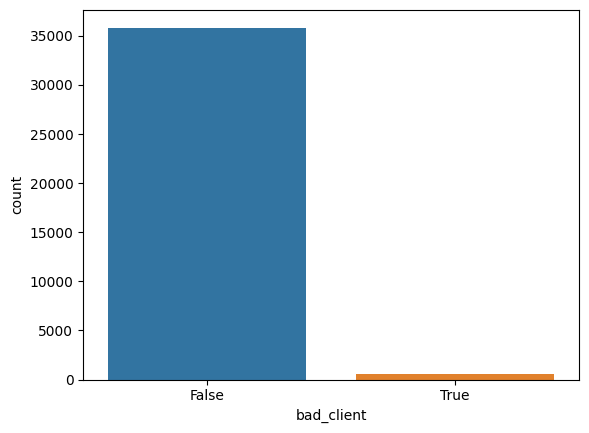

In [524]:
import seaborn as sns 
sns.countplot(data=merged_dataset, x='bad_client')

In [525]:
# Splitting data
filtered_dataset = merged_dataset[merged_dataset['bad_client'].notnull()]
X_data, Y_data = filtered_dataset.drop(columns=['bad_client'], inplace=True), filtered_dataset['bad_client'].astype(numpy.bool_)

/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_2125/2692726248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data, Y_data = filtered_dataset.drop(columns=['bad_client'], inplace=True), filtered_dataset['bad_client'].astype(numpy.bool_)


KeyError: 'bad_client'

In [ ]:
from imblearn.over_sampling import SMOTE 

smote_classifier = SMOTE(k_neighbors=5, random_state=42)

X_sampled, Y_sampled = smote_classifier.fit_resample(X_data, Y_data)

In [528]:
filtered_dataset = pandas.concat([X_sampled, Y_sampled], axis=1)
print(filtered_dataset['bad_client'])

0        False
1        False
2        False
3        False
4        False
         ...  
71677     True
71678     True
71679     True
71680     True
71681     True
Name: bad_client, Length: 71682, dtype: bool


<Axes: xlabel='bad_client', ylabel='count'>

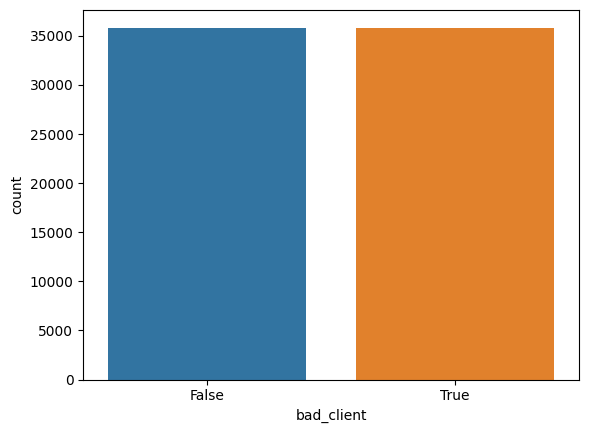

In [529]:
sns.countplot(data=filtered_dataset, x='bad_client')

Merging back to the main dataset

In [531]:
unlabeled = merged_dataset[merged_dataset['bad_client'].isnull()]
merged_dataset = pandas.concat([unlabeled, filtered_dataset], axis=0)

<class 'pandas.core.frame.DataFrame'>
Index: 473735 entries, 12 to 71681
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           473735 non-null  int64  
 1   has_car             473735 non-null  bool   
 2   has_realty          473735 non-null  bool   
 3   total_children      473735 non-null  int8   
 4   annual_income       473735 non-null  int64  
 5   income_category     473735 non-null  int8   
 6   education_category  473735 non-null  int8   
 7   married             473735 non-null  bool   
 8   living_place        473735 non-null  int8   
 9   has_mobile_phone    473735 non-null  bool   
 10  has_work_phone      473735 non-null  int64  
 11  has_phone           473735 non-null  bool   
 12  has_email           473735 non-null  bool   
 13  job                 473735 non-null  int8   
 14  family_size         473735 non-null  float64
 15  age                 473735 non-null  in

Semi Supervised Learning Analysis

In [ ]:
# Separating data into labeled and unlabeled datasets 

labeled_data = merged_dataset[merged_dataset['bad_client'].notnull()]
unlabeled_data = merged_dataset[merged_dataset['bad_client'].isnull()]

In [ ]:
# Splitting data into training, validation and test sets
from sklearn.model_selection import train_test_split 

Xl_data, Yl_data = labeled_data.drop(columns=['bad_client']), labeled_data['bad_client']
X_train, X_test, Y_train, Y_test = train_test_split(Xl_data, Yl_data, stratify=Yl_data, test_size=0.4)

# Splitting into training and validation sets 
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.4)

training_set = (X_train, Y_train)
test_set = (X_test, Y_test)
validation_set = (X_validation, Y_validation)

Semi Supervised Learning (Learning on Labeled Data)

Label Propagation

In [ ]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

Saving new dataset to a CSV File

In [ ]:
merged_dataset.to_csv("ready_dataset.csv")